In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision.datasets
from torchvision import transforms
import PIL
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.optim as optim



    

In [ ]:
data_transforms =transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])


In [3]:
dataset_path = "../Data/train"
imagenet_data = torchvision.datasets.ImageFolder(dataset_path,transform=data_transforms)

total_data = len(imagenet_data)
train_dataset = int(total_data*0.70)
val_dataset = int(total_data*0.15)
test_dataset = int(total_data-train_dataset-val_dataset)

train_set,val_set,test_set = torch.utils.data.random_split(imagenet_data,[train_dataset,val_dataset,test_dataset])

train_dataset = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

val_dataset= torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

test_dataset = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

train_image,train_label =next(iter(train_dataset))
total_data = len(train_dataset)
print(total_data)
print(len(imagenet_data))
print(train_image.shape)

175
8000
torch.Size([32, 3, 224, 224])


<class 'torch.Tensor'>
torch.Size([3, 224, 224])


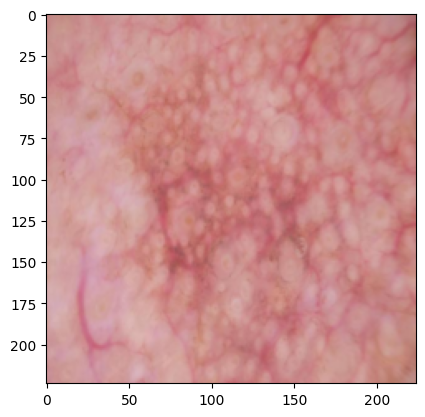

In [4]:
image , label =imagenet_data[0]
print(type(image))
print(image.shape)
plt.imshow(image.permute(1,2,0))

In [5]:
class SkinCancerModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.katman =nn.Sequential(
        nn.Flatten(),
        nn.Linear(150528,224),
        nn.ReLU(),
        nn.Linear(224,7)
    )
    def forward(self, x):
       x = self.katman(x)
       return x
    



        

In [6]:
model = SkinCancerModel()
tahminler = model(train_image)


loss= nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.00001)
print(tahminler.shape)

torch.Size([32, 7])


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [8]:
hata = loss(tahminler,train_label)
print("Eğitimden önceki hata:",hata.item())

optimizer.zero_grad()
hata.backward()
optimizer.step()

yeni_tahminler = model(train_image)
yeni_hata = loss(yeni_tahminler,train_label)


print("Eğitimden sonraki hata:", yeni_hata.item())


Eğitimden önceki hata: 1.7978068590164185
Eğitimden sonraki hata: 1.1086530685424805


In [11]:
criterion= nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.00001)
model =model.to(device)
for epoch in range(5):
    total_loss = 0
    for image ,label in train_dataset:
        image = image.to(device)
        label = label.to(device)
        
        predict = model(image)
        hata = criterion(predict,label)
        optimizer.zero_grad()
        hata.backward()
        optimizer.step()

        total_loss += hata.item()

    print(f"Epoch {epoch+1} tamamlandı. Ortalama Hata: {total_loss/len(train_dataset)}")

Epoch 1 tamamlandı. Ortalama Hata: 1.0890903905459812
Epoch 2 tamamlandı. Ortalama Hata: 1.0170408872195653
Epoch 3 tamamlandı. Ortalama Hata: 0.9873421212605068
Epoch 4 tamamlandı. Ortalama Hata: 0.9760555536406381
Epoch 5 tamamlandı. Ortalama Hata: 0.9615065354960305


In [12]:
criterion= nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.00001)
model =model.to(device)
for epoch in range(5):
    total_loss = 0
    total_accuary = 0
    for image ,label in train_dataset:
        image , label = image.to(device),label.to(device)
        predict = model(image)
        hata = criterion(predict,label)

        optimizer.zero_grad()
        hata.backward()
        optimizer.step()

        total_loss += hata.item()

        tahmin_edilenler = torch.argmax(predict,dim=1)
        paket_dogrusu = (tahmin_edilenler == label).sum().item()
        total_accuary += paket_dogrusu

    ortalama_hata = total_loss / len(train_dataset)

    yuzdelik_basari = (total_accuary / len(train_dataset.dataset)) * 100

    print(f"Epoch {epoch+1} tamamlandı. Ortalama Hata: {total_loss/len(train_dataset)}")


Epoch 1 tamamlandı. Ortalama Hata: 0.9547961793627058
Epoch 2 tamamlandı. Ortalama Hata: 0.9412210651806423
Epoch 3 tamamlandı. Ortalama Hata: 0.9443941283226013
Epoch 4 tamamlandı. Ortalama Hata: 0.9273105251789093
Epoch 5 tamamlandı. Ortalama Hata: 0.9185278793743679


In [13]:
model.eval()
model =model.to(device)
with torch.no_grad():

    criterion= nn.CrossEntropyLoss()

    total_loss = 0
    total_accuary = 0
    for image ,label in test_dataset:
        image , label = image.to(device),label.to(device)
        predict = model(image)
        hata = criterion(predict,label)

        total_loss += hata.item()

        tahmin_edilenler = torch.argmax(predict,dim=1)
        paket_dogrusu = (tahmin_edilenler == label).sum().item()
        total_accuary += paket_dogrusu

    ortalama_hata = total_loss / len(test_dataset)

    yuzdelik_basari = (total_accuary / len(test_dataset.dataset)) * 100

    print(f"🎉 TEST SONUCU | Ortalama Hata: {ortalama_hata:.4f} | Başarı Oranı: %{yuzdelik_basari:.2f}")

    


🎉 TEST SONUCU | Ortalama Hata: 0.8938 | Başarı Oranı: %68.75


In [14]:
import os
torch.save(model.state_dict(), "cepteki_dermatolog_linear_v1.pth")
print("Model dosyası mevcut mu?:", os.path.exists("cepteki_dermatolog_linear_v1.pth"))

Model dosyası mevcut mu?: True


In [15]:

test_model = SkinCancerModel() 
test_model.load_state_dict(torch.load("cepteki_dermatolog_linear_v1.pth"))
test_model.eval()

print("✅ Model başarıyla kaydedildi ve geri yüklendi!")

C:\Users\akarf\AppData\Local\Temp\ipykernel_22048\227473613.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load("cepteki_dermatolog_lin

✅ Model başarıyla kaydedildi ve geri yüklendi!


In [16]:
num_classes = 7
class SkinCancerModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32,kernel_size=3,padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(50176,128)
        self.fc2 = nn.Linear(128,num_classes)

    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        
        x = self.flatten(x)

       
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)

        
        return x
    
new_model = SkinCancerModelV2()



In [17]:
import random as rand
sahte_resim = torch.rand(1, 3, 224, 224)
sonuc = new_model(sahte_resim)
print (sonuc.shape)

torch.Size([1, 7])


In [18]:
model_v2 = SkinCancerModelV2()

In [19]:
import torch
print("PyTorch versiyonu:", torch.__version__)
print("CUDA yüklü mü?:", torch.cuda.is_available())
print("Kaç tane GPU var?:", torch.cuda.device_count())

PyTorch versiyonu: 2.5.1+cu121
CUDA yüklü mü?: True
Kaç tane GPU var?: 1


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
criterion= nn.CrossEntropyLoss()
optimizer = optim.Adam(model_v2.parameters(),lr=0.0001)
model_v2.to(device)
model_v2.train()
for epoch in range(15):
    total_loss = 0
    total_accuary = 0
    for image ,label in train_dataset:
        image = image.to(device)
        label= label.to(device)
        predict = model_v2(image)
        hata = criterion(predict,label)

        optimizer.zero_grad()
        hata.backward()
        optimizer.step()

        total_loss += hata.item()

        tahmin_edilenler = torch.argmax(predict,dim=1)
        paket_dogrusu = (tahmin_edilenler == label).sum().item()
        total_accuary += paket_dogrusu

    ortalama_hata = total_loss / len(train_dataset)

    yuzdelik_basari = (total_accuary / len(train_dataset.dataset)) * 100

    print(f"Epoch {epoch+1} tamamlandı. Ortalama Hata: {total_loss/len(train_dataset)},Yüzdelik Başari: {yuzdelik_basari}")


Using device: cuda
Epoch 1 tamamlandı. Ortalama Hata: 1.1673088594845362,Yüzdelik Başari: 66.64285714285715
Epoch 2 tamamlandı. Ortalama Hata: 0.9920911400658744,Yüzdelik Başari: 66.96428571428571
Epoch 3 tamamlandı. Ortalama Hata: 0.9240050266470228,Yüzdelik Başari: 67.91071428571429
Epoch 4 tamamlandı. Ortalama Hata: 0.8984809144905636,Yüzdelik Başari: 68.25
Epoch 5 tamamlandı. Ortalama Hata: 0.8693651229994638,Yüzdelik Başari: 68.78571428571428
Epoch 6 tamamlandı. Ortalama Hata: 0.8503504530021122,Yüzdelik Başari: 69.125
Epoch 7 tamamlandı. Ortalama Hata: 0.8400623779637473,Yüzdelik Başari: 70.21428571428572
Epoch 8 tamamlandı. Ortalama Hata: 0.8275748683725085,Yüzdelik Başari: 70.69642857142857
Epoch 9 tamamlandı. Ortalama Hata: 0.8131519380637577,Yüzdelik Başari: 70.60714285714286
Epoch 10 tamamlandı. Ortalama Hata: 0.8020561739376613,Yüzdelik Başari: 71.33928571428572
Epoch 11 tamamlandı. Ortalama Hata: 0.7917336343015944,Yüzdelik Başari: 71.42857142857143
Epoch 12 tamamlandı. Or

In [21]:
torch.save(model_v2.state_dict(), 'dermatolog_v2_agirliklar.pth')

🎉 TEST SONUCU | Ortalama Hata: 0.7660 | Başarı Oranı: %69.25


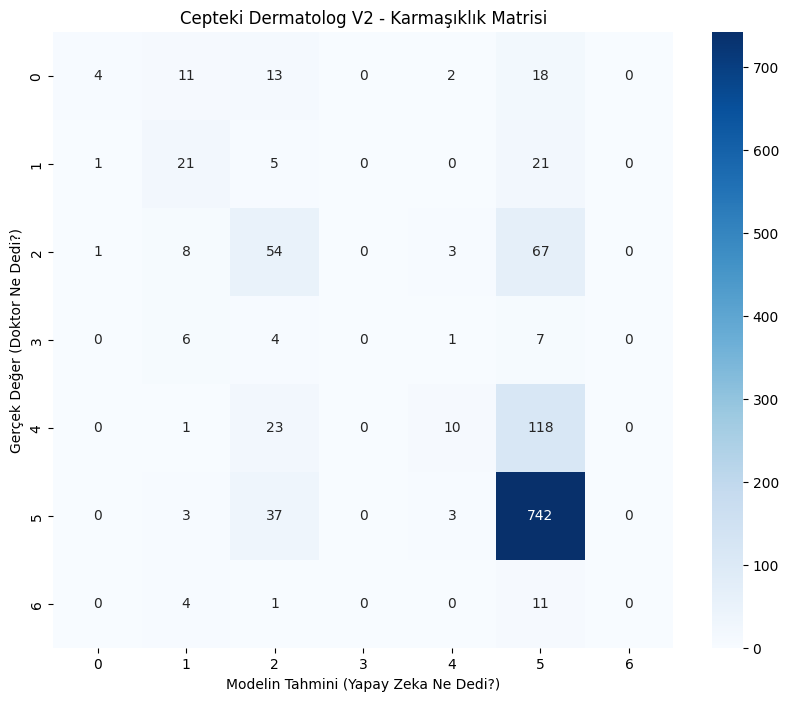

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


model_v2.eval()
model_v2 =model_v2.to(device)
criterion= nn.CrossEntropyLoss()
gercek_etiketler = []
modelin_tahminleri = []

with torch.no_grad():

    total_loss = 0
    total_accuary = 0

    for image ,label in val_dataset:
        image , label = image.to(device),label.to(device)
        predict = model_v2(image)
        hata = criterion(predict,label)

        total_loss += hata.item()

        tahmin_edilenler = torch.argmax(predict,dim=1)

        paket_dogrusu = (tahmin_edilenler == label).sum().item()
        total_accuary += paket_dogrusu

        modelin_tahminleri.extend(tahmin_edilenler.cpu().numpy())
        gercek_etiketler.extend(label.cpu().numpy())

    ortalama_hata = total_loss / len(val_dataset)

    yuzdelik_basari = (total_accuary / len(val_dataset.dataset)) * 100

    print(f"🎉 TEST SONUCU | Ortalama Hata: {ortalama_hata:.4f} | Başarı Oranı: %{yuzdelik_basari:.2f}")




cm = confusion_matrix(gercek_etiketler, modelin_tahminleri)

# 2. Şık Bir Tablo (Heatmap) Olarak Çizdir
plt.figure(figsize=(10, 8)) # Tablonun boyutu
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') # annot=True sayıları gösterir, cmap renk tonudur
plt.xlabel('Modelin Tahmini (Yapay Zeka Ne Dedi?)')
plt.ylabel('Gerçek Değer (Doktor Ne Dedi?)')
plt.title('Cepteki Dermatolog V2 - Karmaşıklık Matrisi')
plt.show()
    
